In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os.path as op
import pandas as pd
from mriqc.viz.misc import raters_variability_plot, plot_abide_stripplots, plot_corrmat, plot_histograms

/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/oesteban/miniconda2/envs/nipypedev-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
data_path = '/home/oesteban/Google Drive/mriqc'
x_path = op.join(data_path, 'aMRIQC_abide_20161130.csv')
y_path = op.join(data_path, 'ABIDE_QC_Marie.csv')

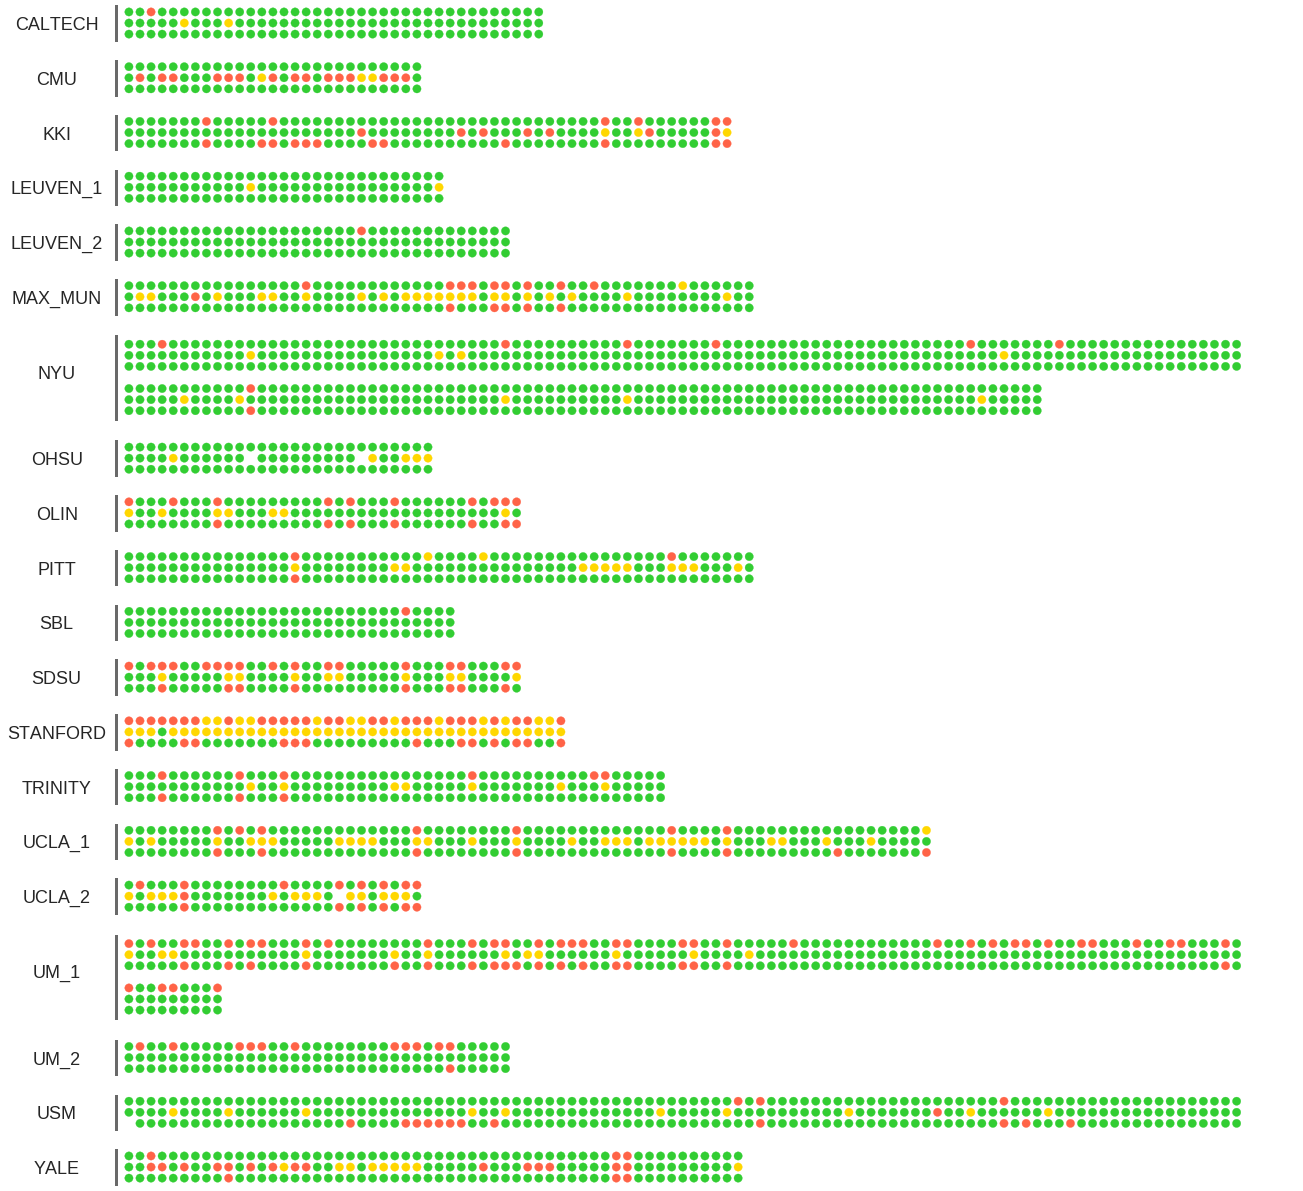

In [26]:
mdata = pd.read_csv(op.join(data_path, 'ABIDE_QC_all.csv'), index_col=False, na_values='n/a', na_filter=False)
fig = raters_variability_plot(mdata)

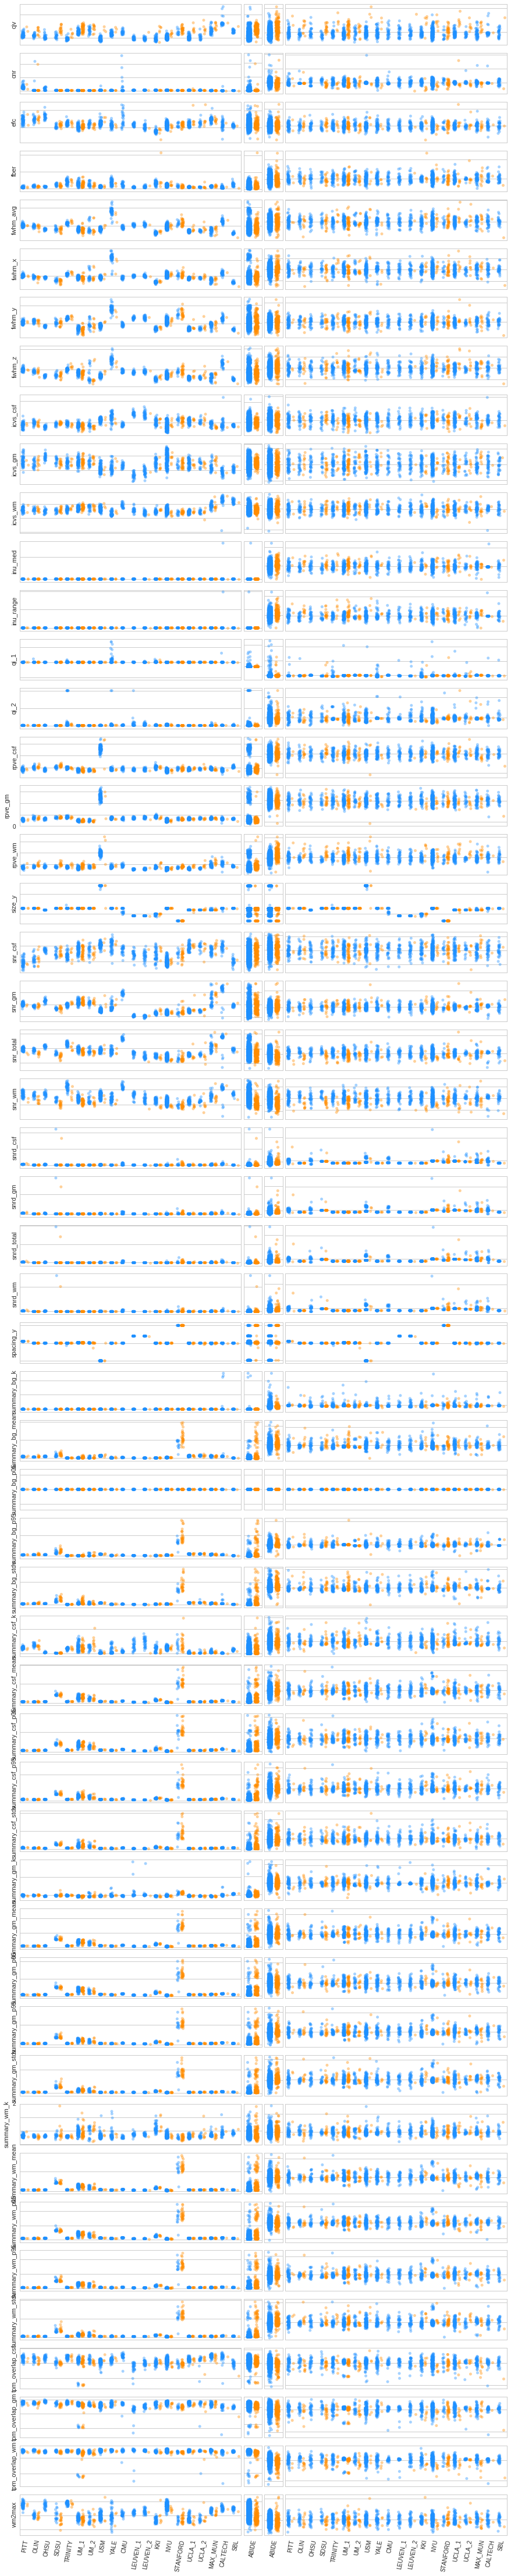

In [30]:
fig = plot_abide_stripplots(x_path, y_path)

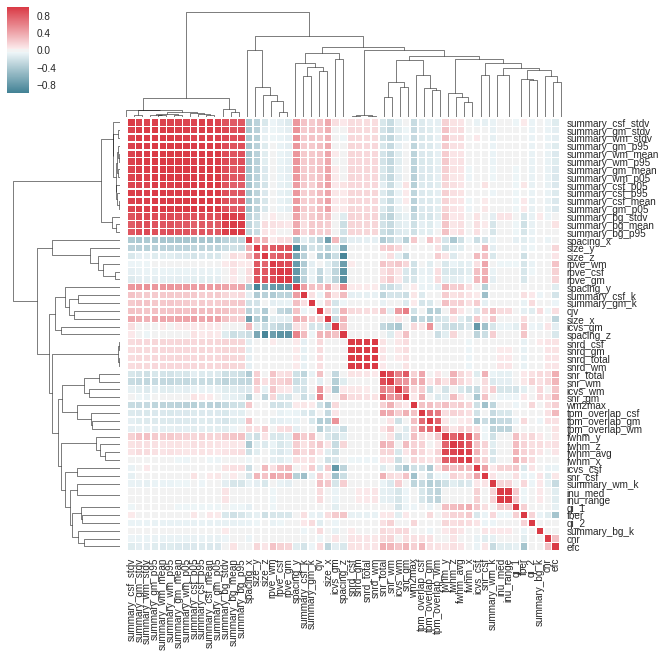

In [35]:
fig = plot_corrmat(x_path)

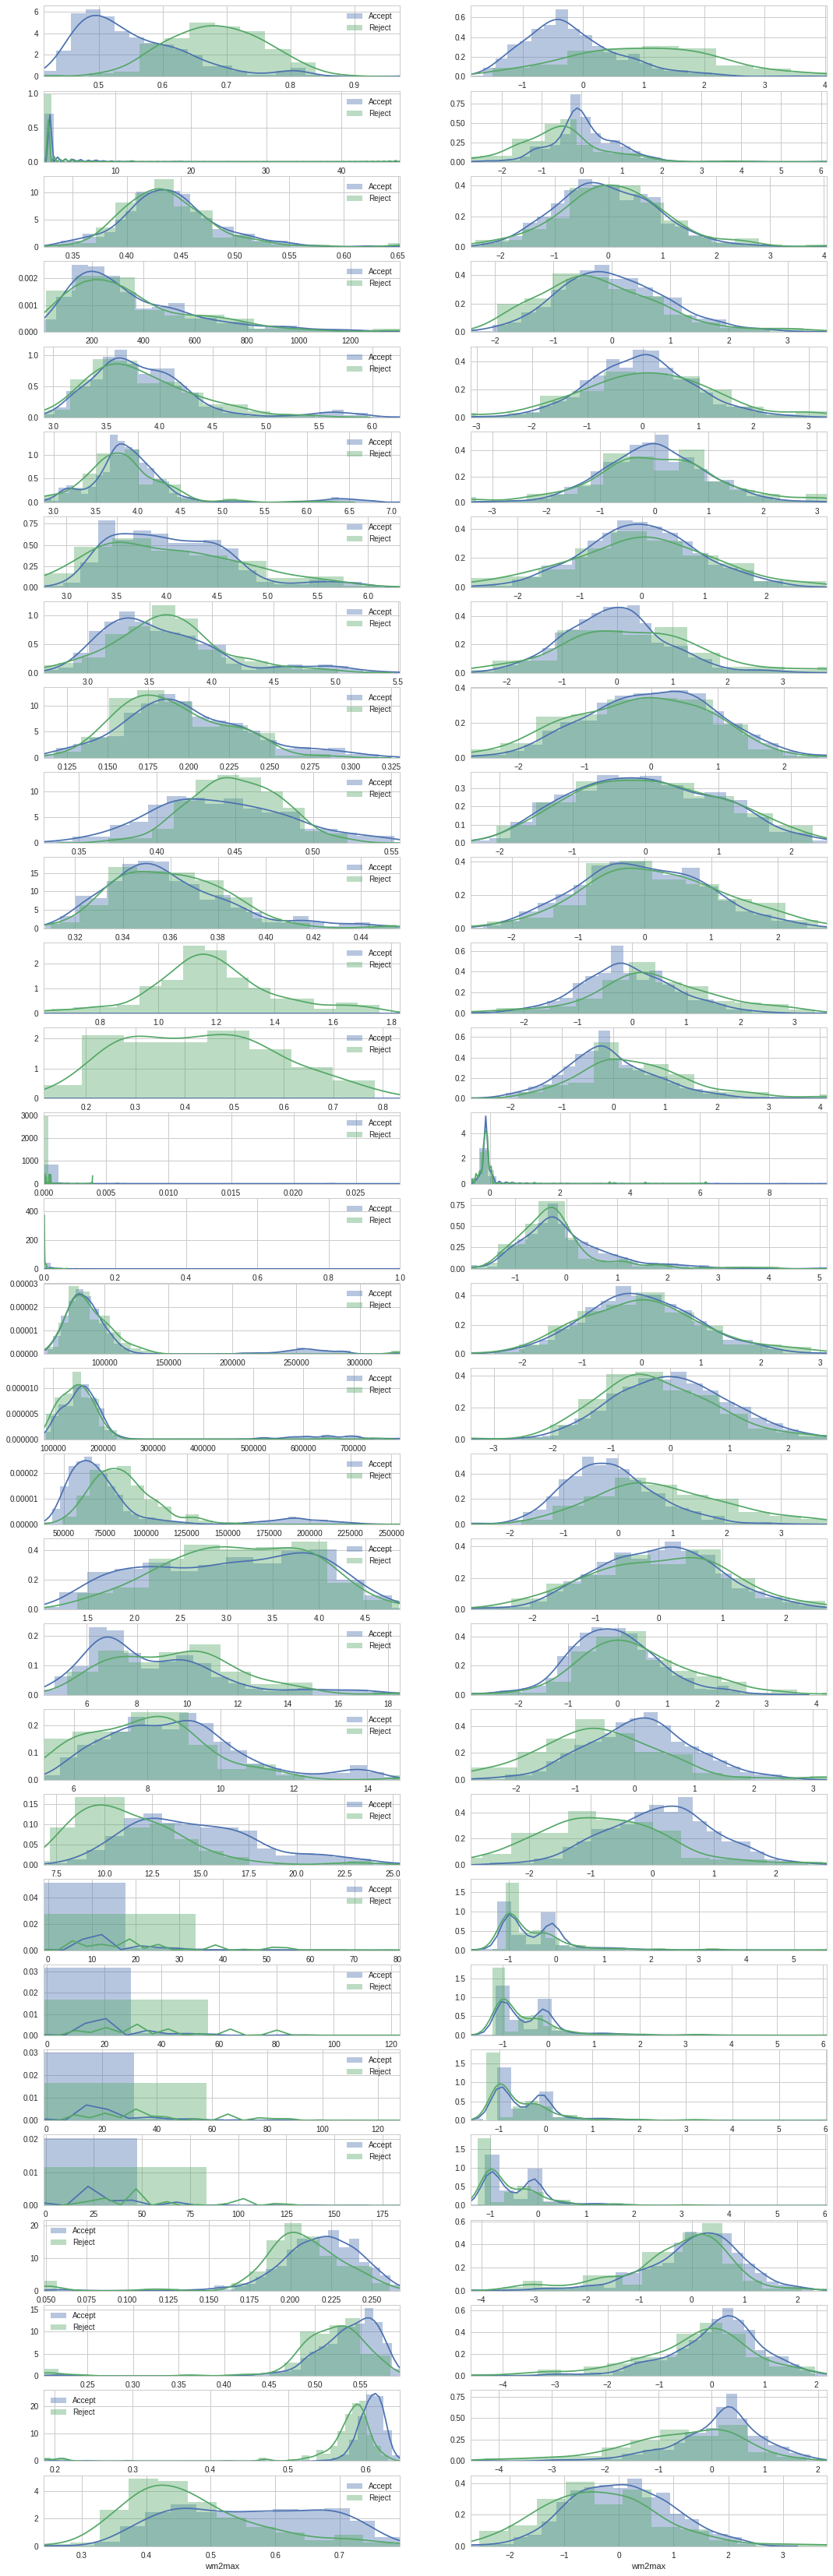

In [44]:
fig = plot_histograms(x_path, y_path)

In [66]:
loso = pd.read_csv(op.join(data_path, 'loso.csv'), index_col=False, na_values='n/a', na_filter=False)
loso['Split'] = ['LoSo'] * len(loso[['clf']].values.ravel())
kfold = pd.read_csv(op.join(data_path, 'kfold.csv'), index_col=False, na_values='n/a', na_filter=False)
kfold['Split'] = ['10-fold'] * len(kfold[['clf']].values.ravel())

cv = loso.append(kfold)

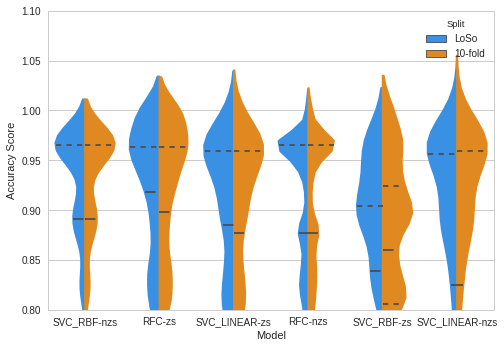

In [69]:
import seaborn as sn

ax = sn.violinplot(
    x='clf', y='accuracy', hue='Split', data=cv, split=True,
    inner="quart", palette={"LoSo": "dodgerblue", "10-fold": "darkorange"})

ax.set_ylim([0.8, 1.1])
ax.set_ylabel('Accuracy Score')
ax.set_xlabel('Model')